In [1]:
# Import necessary libraries for data manipulation and visualization
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.utils import resample,shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV ,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import numpy as np
from scipy import stats


# Data Exploration and Preprocessing

In [2]:
data = pd.read_csv('C:\\Users\\Admin\\Downloads\\water_potability.csv')
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [3]:
data.tail()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1
3275,7.874671,195.102299,17404.177061,7.509306,NaN,327.459760,16.140368,78.698446,2.309149,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
data.fillna(data.median(), inplace=True)
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

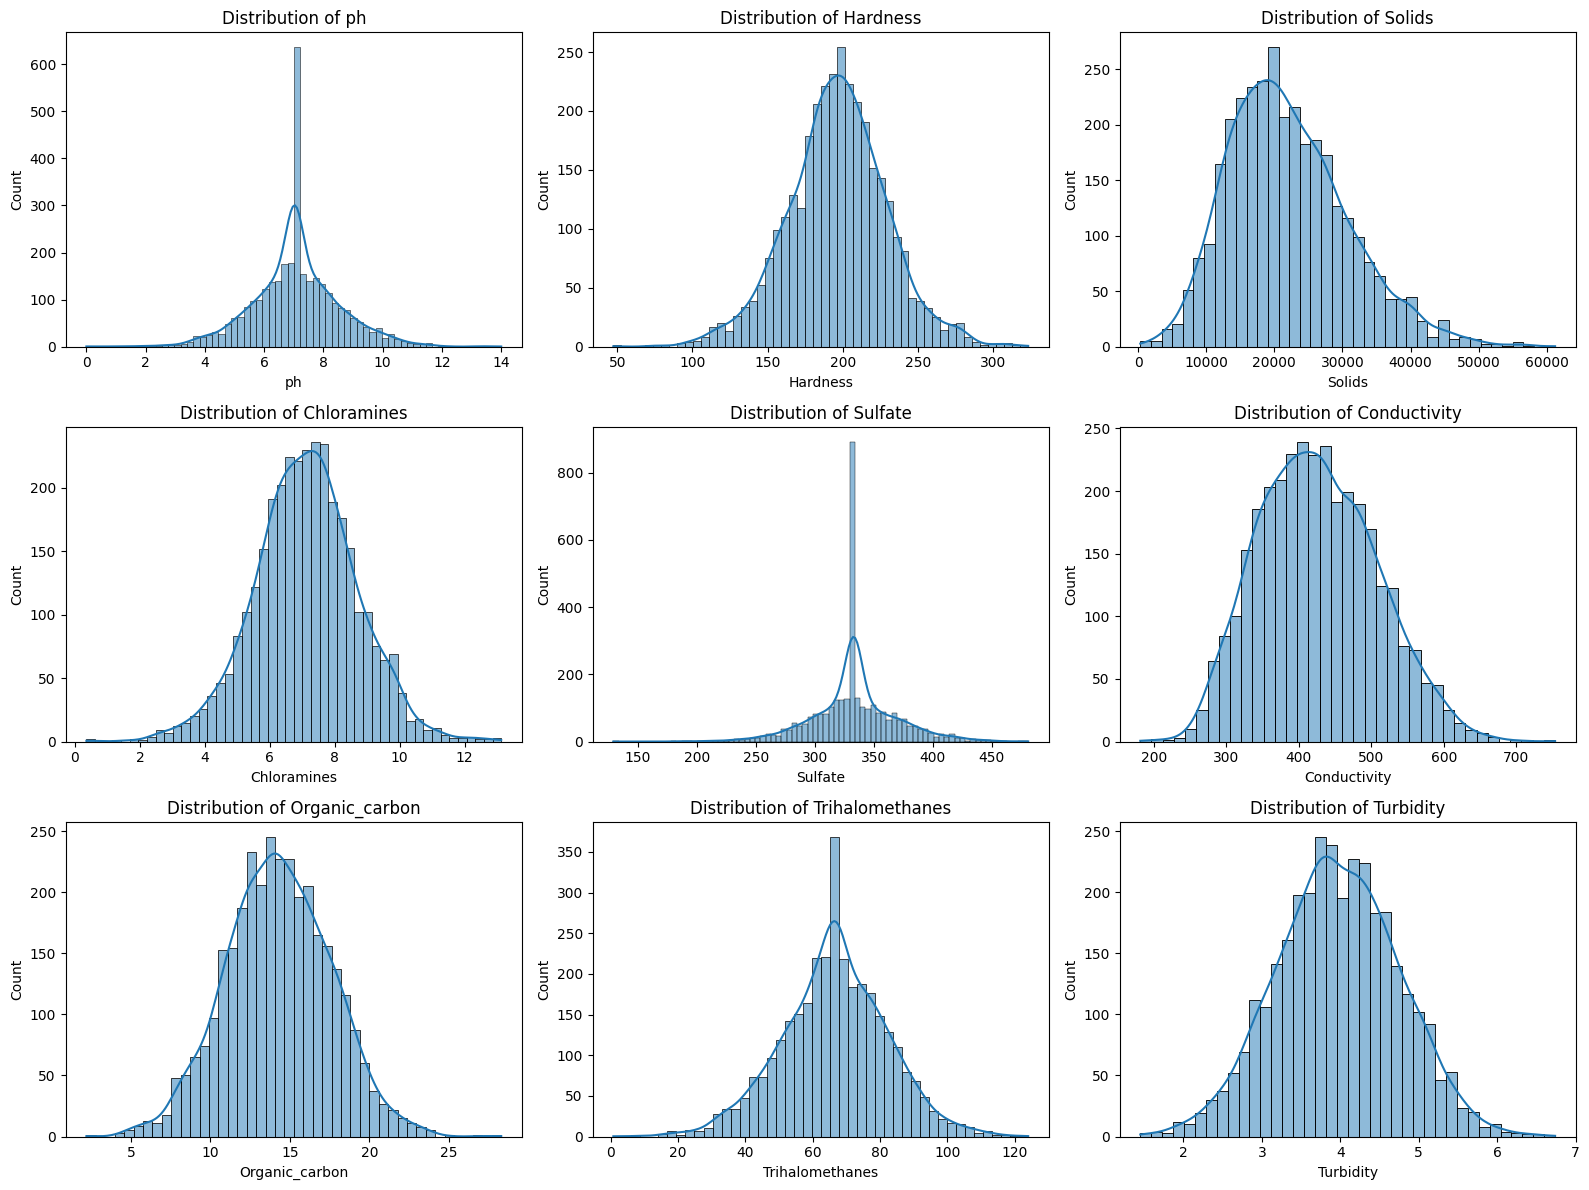

In [7]:
# Visualizing distributions
features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
target = 'Potability'

plt.figure(figsize=(16, 12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [8]:
# Z-score for outlier detection (absolute value > 3 indicates an outlier)
z_scores = stats.zscore(data[features])
outliers = (abs(z_scores) > 3).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")

Number of outliers: 148


# Feature Engineering

In [9]:
data.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075760,-0.082004,-0.031741,0.014178,0.017466,0.040240,0.003145,-0.036107,-0.003014
Hardness,0.075760,1.000000,-0.046899,-0.030054,-0.092833,-0.023915,0.003610,-0.012707,-0.014449,-0.013837
Solids,-0.082004,-0.046899,1.000000,-0.070148,-0.149747,0.013831,0.010242,-0.008799,0.019546,0.033743
Chloramines,-0.031741,-0.030054,-0.070148,1.000000,0.023762,-0.020486,-0.012653,0.016614,0.002363,0.023779
Sulfate,0.014178,-0.092833,-0.149747,0.023762,1.000000,-0.014182,0.027102,-0.025657,-0.009767,-0.020476
Conductivity,0.017466,-0.023915,0.013831,-0.020486,-0.014182,1.000000,0.020966,0.001184,0.005798,-0.008128
Organic_carbon,0.040240,0.003610,0.010242,-0.012653,0.027102,0.020966,1.000000,-0.012958,-0.027308,-0.030001
Trihalomethanes,0.003145,-0.012707,-0.008799,0.016614,-0.025657,0.001184,-0.012958,1.000000,-0.021487,0.006887
Turbidity,-0.036107,-0.014449,0.019546,0.002363,-0.009767,0.005798,-0.027308,-0.021487,1.000000,0.001581
Potability,-0.003014,-0.013837,0.033743,0.023779,-0.020476,-0.008128,-0.030001,0.006887,0.001581,1.000000


In [10]:
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [11]:
X = data.drop(['Potability'], axis=1)
y = data['Potability']

In [12]:
features_scaler = MinMaxScaler()
X = features_scaler.fit_transform(X)
X

array([[0.50262515, 0.57113901, 0.33609646, ..., 0.31340165, 0.69975313,
        0.28609102],
       [0.26543429, 0.29740043, 0.30061142, ..., 0.49731851, 0.4509993 ,
        0.57679264],
       [0.57850887, 0.64131081, 0.32161885, ..., 0.56201674, 0.5328657 ,
        0.30363656],
       ...,
       [0.67282217, 0.46548556, 0.53910122, ..., 0.33866167, 0.56065454,
        0.34956996],
       [0.36619735, 0.66440723, 0.19148981, ..., 0.34363779, 0.62265916,
        0.61611996],
       [0.56247653, 0.53563505, 0.28048408, ..., 0.5341137 , 0.63247754,
        0.16244074]])

# Handling Class Imbalance

In [13]:
y.value_counts()

Potability
0    1998
1    1278
Name: count, dtype: int64

In [14]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)
y.value_counts()

Potability
0    1998
1    1998
Name: count, dtype: int64

# Model Selection and Training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Cross-validation for comparison of classifiers
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print(f"{name}: Accuracy = {scores.mean():.2f}")


Random Forest: Accuracy = 0.70
KNN: Accuracy = 0.65
SVC: Accuracy = 0.61
Decision Tree: Accuracy = 0.61


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

XGBoost: Accuracy = 0.66


In [17]:
xgbclf = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    early_stopping_rounds=100,
    max_depth=10,
    min_child_weight=2,
    gamma=1,
    colsample_bytree=0.8,
    subsample=0.8,
    objective= 'binary:logistic',
    nthread=-2,
    random_state=42
)

xgbclf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=200)

[0]	validation_0-logloss:0.69202
[200]	validation_0-logloss:0.60444
[400]	validation_0-logloss:0.57882
[600]	validation_0-logloss:0.56966
[800]	validation_0-logloss:0.56541
[999]	validation_0-logloss:0.56434


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=-2,
              num_parallel_tree=None, ...)

In [18]:
acc_train = accuracy_score(xgbclf.predict(X_train),y_train)
acc_val = accuracy_score(xgbclf.predict(X_test),y_test)

print(f"model: xgbclf\ntrain_accuracy: {acc_train:.2f}\ntest_accuracy: {acc_val:.2f}")


model: xgbclf
train_accuracy: 0.99
test_accuracy: 0.72


In [19]:
imputer = SimpleImputer(strategy='mean')  
X_imputed = imputer.fit_transform(X)

In [20]:
df_cleaned = pd.DataFrame(X_imputed, columns=features).drop_duplicates()

In [21]:
X_cleaned = df_cleaned.values
y_cleaned = y.loc[df_cleaned.index].values  
print(y_cleaned)

[0 0 0 ... 1 1 1]


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)
print(X_scaled)

[[-0.02148047  0.26770903 -0.13016931 ... -1.20362054  1.32034342
  -1.3214337 ]
 [-2.36717783 -2.05247436 -0.37852456 ...  0.27718339 -0.65457346
   0.69854652]
 [ 0.72897106  0.86247886 -0.23149626 ...  0.79810026 -0.00461628
  -1.19951609]
 ...
 [-0.9168921  -0.55962158 -0.10336809 ... -1.01763893 -0.38847261
   0.06155161]
 [ 0.10454686 -1.02411492  2.61109338 ...  0.40429219 -0.37994849
   0.08464966]
 [ 0.10689136  0.21761958 -0.11799411 ...  0.33888744 -1.32783702
   1.07319826]]


In [23]:
not_potable  = data[data['Potability']==0]
potable = data[data['Potability']==1]  

In [24]:
df_upsampled = resample(potable, replace = True, n_samples = 1200) 
print(df_upsampled)

            ph    Hardness        Solids  Chloramines     Sulfate  \
760   7.581945  193.286463  21675.682866     9.821499  381.930744   
393   6.775583  218.414929  17968.882775     8.254115  333.073546   
2412  7.446226  241.573862  13312.446107     4.532979  333.073546   
1209  7.828740  176.727511  33337.109649     5.438776  286.992631   
1084  8.154532  168.098935  21361.197053     6.198844  333.073546   
...        ...         ...           ...          ...         ...   
2033  8.549693  236.861505  17828.294524     4.752268  341.036337   
754   8.581429  186.601621  20590.712114     3.924183  366.131900   
1168  5.473603  218.513145  14608.363145     5.621362  333.073546   
2343  2.538116  100.806520  19872.854854     5.014023  418.000000   
2751  5.796237  156.347095  15671.119287     8.408832  333.073546   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
760     414.810985       16.109169        92.609084   4.833346           1  
393     358.71767

In [25]:
#shuffle randomly re-ordering the data
data = pd.concat([not_potable, df_upsampled])
data = shuffle(data) 
print(data)

             ph    Hardness        Solids  Chloramines     Sulfate  \
1142   4.923179  208.406673  15990.149228     5.648146  349.655175   
2895  13.349889  152.776455  18464.900775     6.717973  334.864070   
2611   5.517737  190.669928  17638.322473    10.525858  333.073546   
1113   8.775486  157.354289  22113.391452     7.931503  304.807845   
2922   8.886979  180.563966  26062.447217     8.808963  327.223580   
...         ...         ...           ...          ...         ...   
1449  10.848130  236.725049  14036.163656     9.002885  333.073546   
1452   8.174028  192.390430  19808.537766     6.955821  377.700189   
171    7.036752  233.850345  21136.286764     6.689878  333.073546   
2279   7.539742  201.959317  26716.359708     5.637350  333.073546   
580    6.760791  192.142621  19089.948557     4.364521  345.018897   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
1142    404.405763       11.403372        84.525775   3.329601           1  
2895 

In [26]:
x = data.drop(['Potability'], axis = 1)
y = data['Potability']

In [27]:
st = StandardScaler()
col= x.columns
x[col] = st.fit_transform(x[col])
x[col]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
1142,-1.454815,0.365394,-0.681635,-0.934191,0.436591,-0.264008,-0.862230,1.140821,-0.818137
2895,4.222920,-1.324824,-0.395836,-0.260817,0.016763,0.310999,0.881559,1.226669,-1.836329
2611,-1.054214,-0.173503,-0.491294,2.135951,-0.034058,0.448218,-0.522366,-1.365416,0.703688
1113,1.140786,-1.185735,0.025515,0.503006,-0.836346,0.680821,0.429820,1.039882,0.538996
2922,1.215908,-0.480554,0.481576,1.055299,-0.200103,-0.582794,1.009904,-1.138544,0.969020
...,...,...,...,...,...,...,...,...,...
1449,2.537289,1.225794,-0.907293,1.177358,-0.034058,1.723194,0.945794,0.008828,-1.067752
1452,0.735537,-0.121229,-0.240664,-0.111110,1.232614,0.963207,-0.146062,-0.438810,0.019826
171,-0.030735,1.138451,-0.087327,-0.278501,-0.034058,-1.151371,-1.361670,0.698487,-0.842036
2279,0.308169,0.169503,0.557094,-0.940985,-0.034058,1.122091,0.216804,1.078291,0.305314


In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.1)

In [29]:
X_train.value_counts()

ph         Hardness   Solids     Chloramines  Sulfate    Conductivity  Organic_carbon  Trihalomethanes  Turbidity
-2.024332  -0.319877  -1.376232   2.282359    -0.034058  -1.459176     -1.374533       -0.134155         1.042793    5
-0.078891  -1.023333   0.279428   1.257213    -0.752575   0.805879      0.375366        2.289684        -0.002441    5
-2.020508   0.168875  -0.154346  -3.280598     0.207874   0.121130     -0.614239        0.177476        -1.270450    4
-1.963471  -0.973145   0.227653   0.919883    -0.034058   1.507309     -0.127230        0.288565        -1.487656    4
-0.043845  -0.797495  -0.198996  -1.206016     1.247566   1.077690      0.373539       -0.117473         1.183766    4
                                                                                                                    ..
-2.681835   0.064054   2.685787   0.433862    -0.273318   0.018428      0.380807       -0.752961         0.353000    1
-2.650412  -1.643979   0.157610   0.721902    -1.1669

# Hyperparameter Tuning

In [30]:
xgb =XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)
parameters_xgb = {'n_estimators': [50,100,250,400,600,800,1000], 'learning_rate': [0.2,0.5,0.8,1]}
rands_xgb =  RandomizedSearchCV(xgb, param_distributions=parameters_xgb, cv=5)

rands_xgb.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'learning_rate': [0.2, 0.5, 0.8, 1],
                                        'n_estimators': [50, 100, 250, 400, 600,
                                                         800, 1000]})

In [50]:
print(rands_xgb.best_params_)

{'n_estimators': 100, 'learning_rate': 0.2}


In [31]:
y_pred = rands_xgb.predict(X_test)
accuracy = accuracy_score(Y_test,y_pred)
print(accuracy)

0.8125


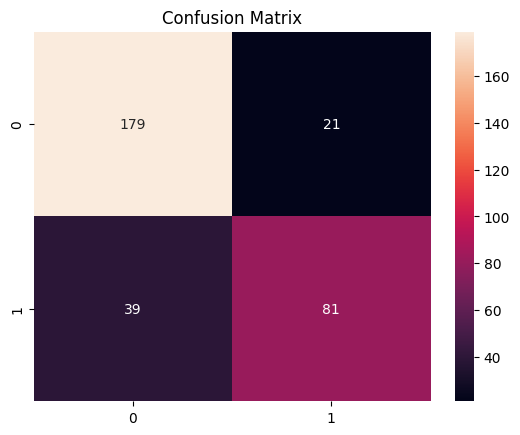

In [32]:
# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

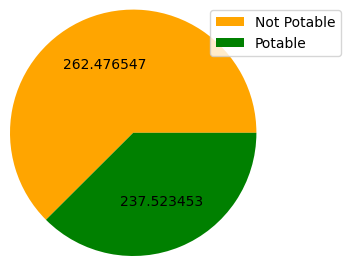

In [33]:
plt.figure(figsize=(2,2))
plt.pie(data['Potability'].value_counts(), autopct="2%f", colors=['orange', 'green'], radius=2)
plt.legend(['Not Potable','Potable'],loc=(1,1));

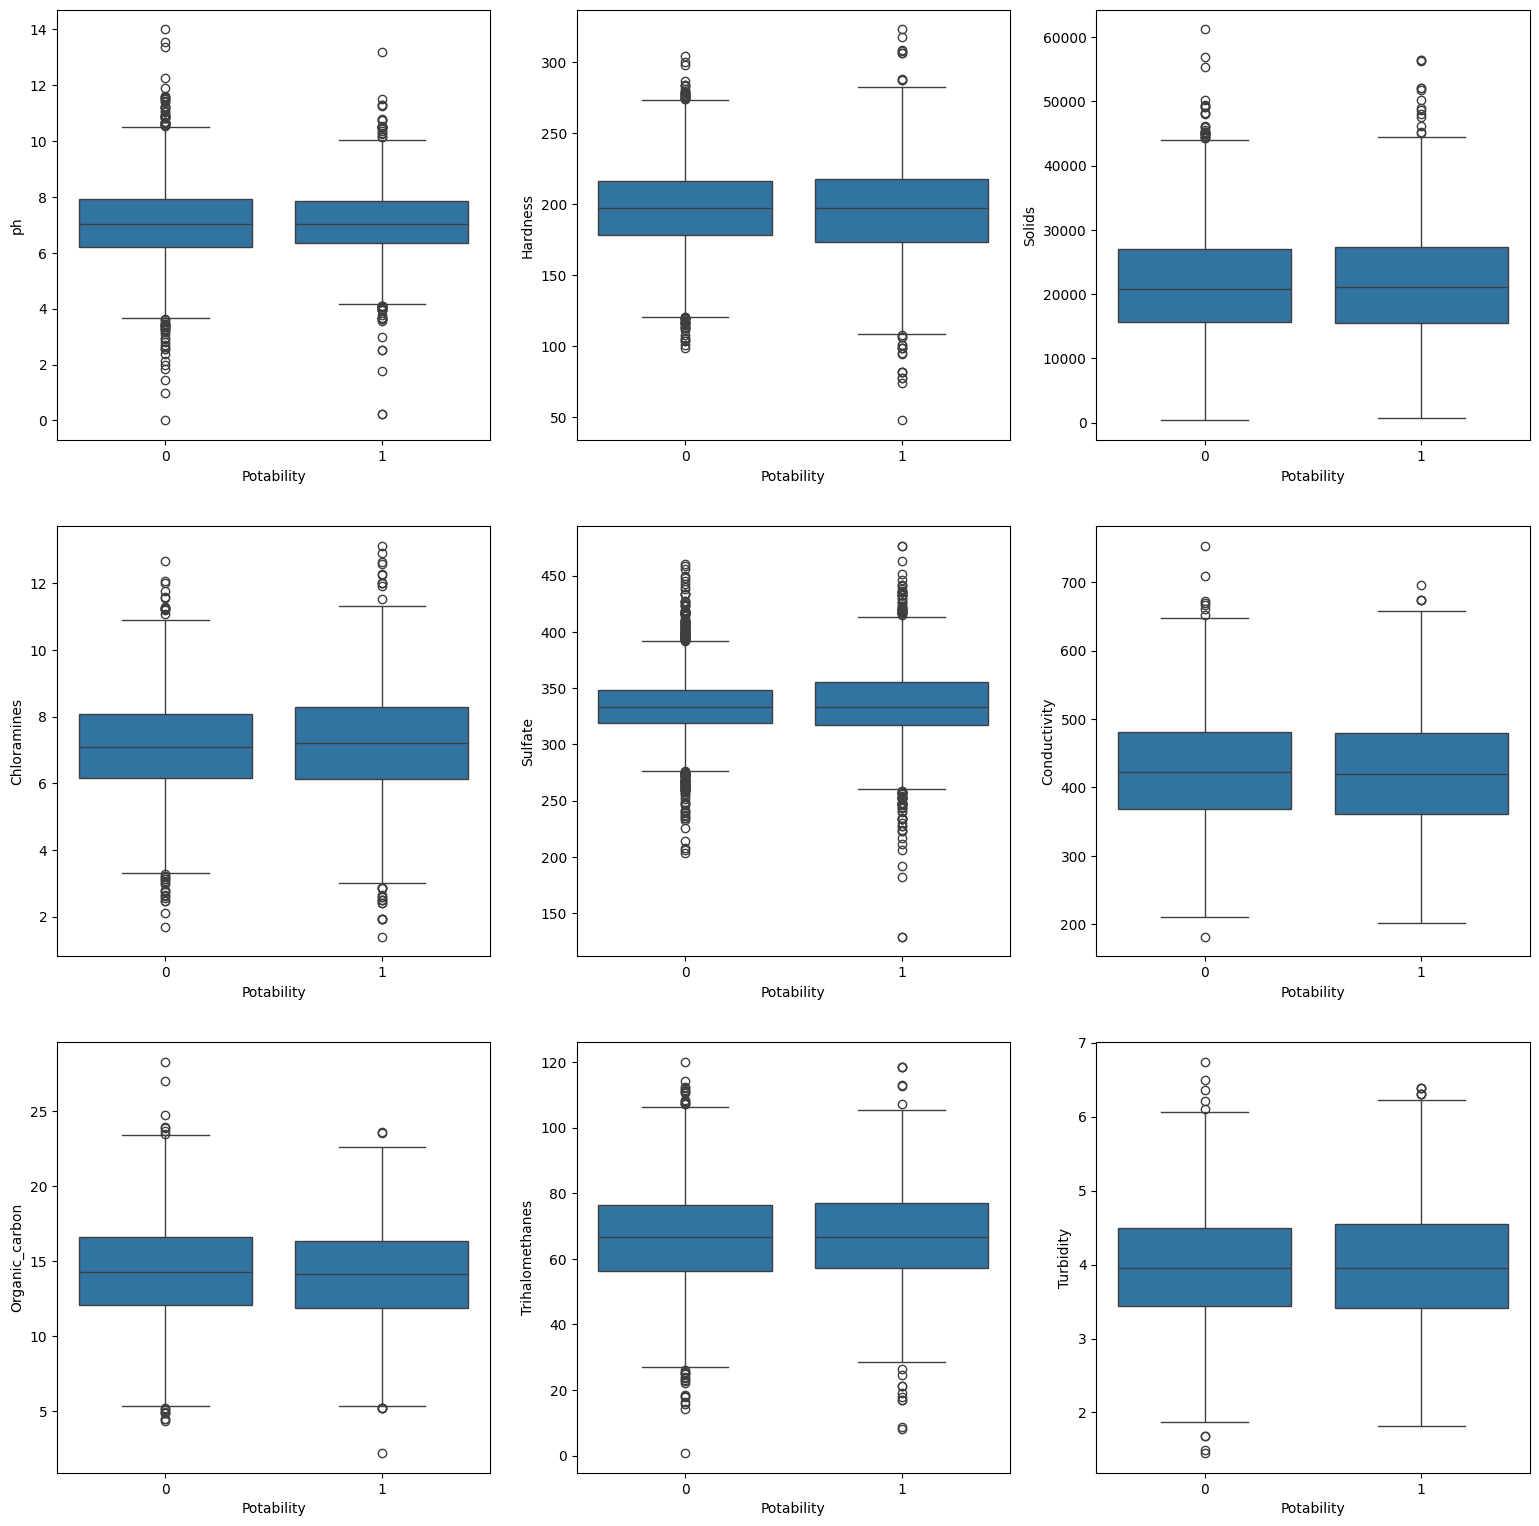

In [34]:
used_attribute_list=[]
fig, axes = plt.subplots(3,3, figsize=(19, 19))
k=0
for i in [0, 1, 2]:
    for j in [0,1,2]:
        sns.boxplot(x=data.Potability, y=data[features[k]], ax=axes[i,j])
        k=k+1

<Axes: >

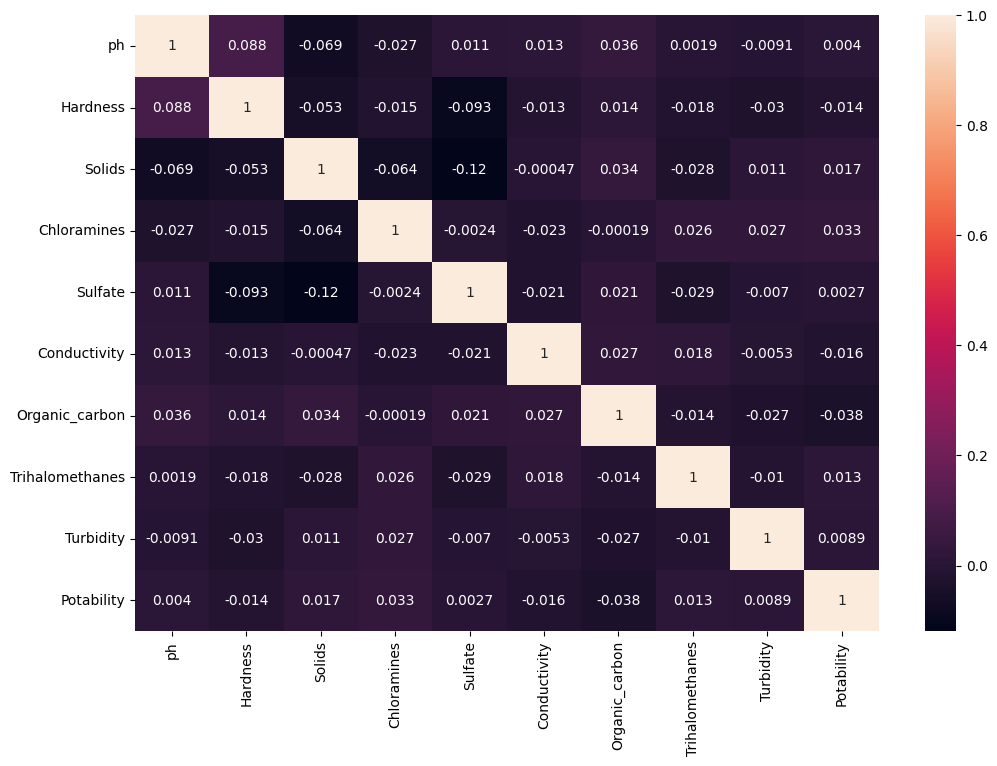

In [35]:
plt.figure(figsize = (12,8))
sns.heatmap(data.corr(), annot = True)

# Model Evaluation

In [36]:
print("Classification Report for XGBClassifier:")
print(classification_report(Y_test, y_pred))

Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       200
           1       0.79      0.68      0.73       120

    accuracy                           0.81       320
   macro avg       0.81      0.79      0.79       320
weighted avg       0.81      0.81      0.81       320



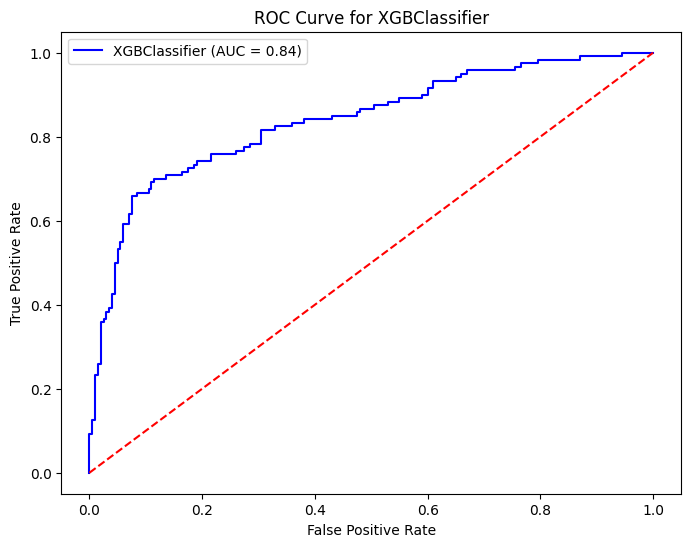

In [37]:
y_pred_proba_xgbclf = rands_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(Y_test, y_pred_proba_xgbclf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'XGBClassifier (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve for XGBClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [38]:
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = KNeighborsClassifier(n_neighbors=5)
clf4 = SVC(probability=True, random_state=42)
clf5 = DecisionTreeClassifier(random_state=42)
clf6 = XGBClassifier(eval_metric='logloss', random_state=42)

In [39]:
clf1.fit(X_train, Y_train)
clf2.fit(X_train, Y_train)
clf3.fit(X_train, Y_train)
clf4.fit(X_train, Y_train)
clf5.fit(X_train, Y_train)
clf6.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [40]:
y_pred = clf1.predict(X_test)  
accuracy_clf1 = accuracy_score(Y_test, y_pred)  
print(f"Accuracy of Logic reg: {accuracy_clf1:.2f}")
print(f"Classification Report for Logic reg:\n", classification_report(Y_test, y_pred))

Accuracy of Logic reg: 0.62
Classification Report for Logic reg:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77       200
           1       0.00      0.00      0.00       120

    accuracy                           0.62       320
   macro avg       0.31      0.50      0.38       320
weighted avg       0.39      0.62      0.48       320



c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [41]:
y_pred = clf2.predict(X_test)  
accuracy_clf2 = accuracy_score(Y_test, y_pred)  
print(f"Accuracy of randforclassi: {accuracy_clf2:.2f}")
print(f"Classification Report for randforclassi:\n", classification_report(Y_test, y_pred))

Accuracy of randforclassi: 0.84
Classification Report for randforclassi:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88       200
           1       0.90      0.66      0.76       120

    accuracy                           0.84       320
   macro avg       0.86      0.81      0.82       320
weighted avg       0.85      0.84      0.84       320



In [42]:
y_pred = clf3.predict(X_test)  
accuracy_clf3 = accuracy_score(Y_test, y_pred)  
print(f"Accuracy of K-Nearest: {accuracy_clf3:.2f}")
print(f"Classification Report for K-Nearest:\n", classification_report(Y_test, y_pred))

Accuracy of K-Nearest: 0.64
Classification Report for K-Nearest:
               precision    recall  f1-score   support

           0       0.69      0.79      0.73       200
           1       0.53      0.40      0.45       120

    accuracy                           0.64       320
   macro avg       0.61      0.59      0.59       320
weighted avg       0.63      0.64      0.63       320



In [43]:
y_pred = clf4.predict(X_test)  
accuracy_clf4 = accuracy_score(Y_test, y_pred)  
print(f"Accuracy of SVC: {accuracy_clf4:.2f}")
print(f"Classification Report for SVC:\n", classification_report(Y_test, y_pred))

Accuracy of SVC: 0.70
Classification Report for SVC:
               precision    recall  f1-score   support

           0       0.69      0.94      0.79       200
           1       0.74      0.29      0.42       120

    accuracy                           0.70       320
   macro avg       0.72      0.62      0.61       320
weighted avg       0.71      0.70      0.65       320



In [44]:
y_pred = clf5.predict(X_test)  
accuracy_clf5 = accuracy_score(Y_test, y_pred)  
print(f"Accuracy of dt: {accuracy_clf5:.2f}")
print(f"Classification Report for dt:\n", classification_report(Y_test, y_pred))

Accuracy of dt: 0.72
Classification Report for dt:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76       200
           1       0.61      0.72      0.66       120

    accuracy                           0.72       320
   macro avg       0.71      0.72      0.71       320
weighted avg       0.73      0.72      0.72       320



In [45]:
y_pred = clf6.predict(X_test)  
accuracy_clf6 = accuracy_score(Y_test, y_pred)  
print(f"Accuracy of XGBoost: {accuracy:.2f}")
print(f"Classification Report for XGBoost:\n", classification_report(Y_test, y_pred))

Accuracy of XGBoost: 0.81
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       200
           1       0.75      0.68      0.72       120

    accuracy                           0.80       320
   macro avg       0.79      0.77      0.78       320
weighted avg       0.79      0.80      0.79       320



# Feature Importance (Tree-Based Models):


In [46]:
importances = clf2.feature_importances_
print(importances)

[0.12731154 0.12045813 0.11368321 0.11652035 0.11806319 0.10332012
 0.10076014 0.09948126 0.10040206]


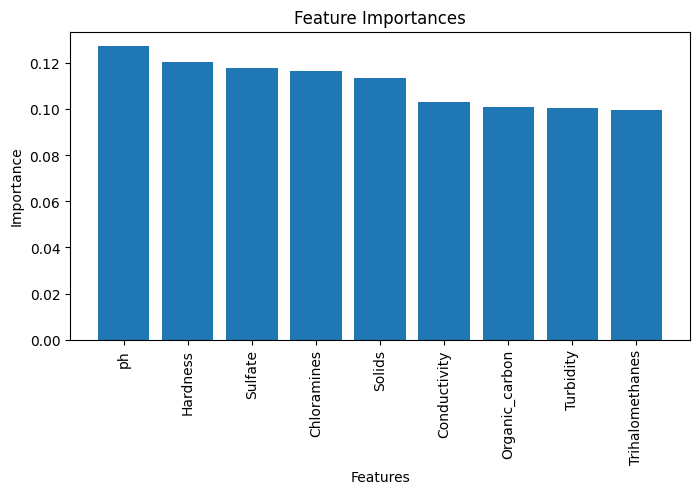

In [47]:
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

plt.figure(figsize=(8, 4))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# Results and Visualization

,Model,Accuracy_score
1,Random Forest,0.843750
5,XGBoost,0.796875
4,Decision Tree,0.718750
3,SVC,0.696875
2,K-Nearest,0.640625
0,Logic reg,0.625000


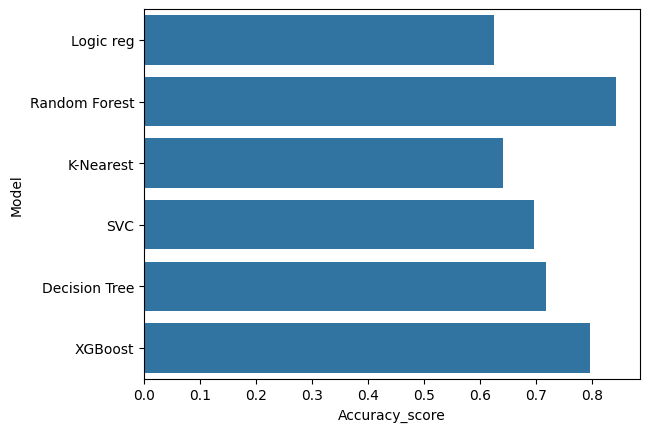

In [48]:
models = pd.DataFrame({
    'Model':['Logic reg','Random Forest','K-Nearest','SVC' ,'Decision Tree','XGBoost'],
    'Accuracy_score' :[accuracy_clf1, accuracy_clf2, accuracy_clf3, accuracy_clf4, accuracy_clf5 ,accuracy_clf6]
})
models
sns.barplot(x='Accuracy_score', y='Model', data=models)
models.sort_values(by='Accuracy_score', ascending=False)